# dev measure birth/death events recursively

In [1]:
from lib.my_initialization import *
from lib.controller.controller_LR import get_one_step_explicit_synchronous_splitting
from lib.model.LR_model import *
from lib.utils.utils_traj import *
from lib.routines.bdrates import *
from lib.measure.utils_measure_tips_cpu import *
from lib.utils.stack_txt_LR import *
from lib.viewer import *
import trackpy
from lib.utils import load_buffer
from lib.routines.return_min_distance import *

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# identify two time ordered death events

In [2]:
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_218.8.npz'
t=218.8
dt=0.01
txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
print(f"txt.shape={txt.shape}")

V_threshold=-50
jump_threshold = 40
ds=5.0
# get_one_step
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt,width,height,ds,diffCoef=0.0005,Cm=1.0)

#the heavyweight spiral tip measures
comp_dict_tips=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0,
                                             jump_threshold=jump_threshold,ds=ds)
# comp_dict_tips=get_compute_all_spiral_tips(width, height, mode='simp')
comp_distance=get_distance_L2_pbc(width,height)
#measure tips that are already present topologically (slower)
img=inVc[...,0];dimgdt=dVcdt[...,0]
# dict_topo=comp_dict_topo_simple(img,dimgdt,t)
dict_topo=comp_dict_tips(img,dimgdt,t,txt)
pid_lst_all=dict_topo['pid']
n_tips=len(pid_lst_all)
print(f'ntips={n_tips}')
#initialize system
pdict=ParticlePBCDict(dict_tips=dict_topo, width=width, height=width)#, **kwargs)
t_prev=t;txt_prev=txt.copy()
# #zoom system (increases runtime and precision at long timescales)
# txt,pdict=zoom_system(txt,pdict)
# txt,pdict=zoom_system(txt,pdict)
# dt=dt/10
# width,height=txt.shape[:2]
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
x_values,y_values,pid_values=pdict.get_current_locations()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img=inVc[...,0];dimgdt=dVcdt[...,0]

scale=ds/width
xy_values=np.array(tuple(zip(x_values,y_values)))
assert(xy_values[0].shape[0]==2)

#compute minimum distance of all pid found
item_lst=[]
for i in range(n_tips):
    for j in range(n_tips):
        if i > j:
            #the ith tip location
            point1=xy_values[i]
            #the jth tip location
            point2=xy_values[j]
            #their distance, in cm
            dist=comp_distance(point1,point2)
            #add to list of distances
            item=(dist,i,j)
            item_lst.append(item)
item_lst=sorted(item_lst)
item_lst

#identify the pairs to follow to existential event
num_pairs_to_follow=2
pid_pair_lst=[]
for item in item_lst[:num_pairs_to_follow]:
    d,i,j=item
    pid_pair=i,j
    pid_pair_lst.append(pid_pair)


#define initialization target points as
point_target_init_lst=[]
for pid_pair in pid_pair_lst:
    #the  mean location of these tips 
    point_target_init=np.mean((x_values[pid_pair[0]],x_values[pid_pair[1]])),np.mean((y_values[pid_pair[0]],y_values[pid_pair[1]]))
    point_target_init_lst.append(point_target_init)

#set range to some value
#the ith tip location
point1=np.array(point_target_init_lst[0])
#the jth tip location
point2=np.array(point_target_init_lst[1])
#their distance, in cm
r=comp_distance(point1,point2)*scale #cm distance between the targets
print(f'there are {r:.3f} cm distance between the first and second targets.')

(200, 200, 18)
ntips=4


# estimate time ordering the death events (~7 min runtime...)

In [110]:
#find txt_prev, and approximate time of death for each tip
t_death_lst=[]
for pid_pair in pid_pair_lst:
    #TODO: def follows_pair_to_death(txt,pdict,pid_pair,atol,dt,ds):
    #slow high precision method
    # txt_prev,t_prev,min_sigma_max=find_stopping_point(dt, pdict, txt_prev, t_prev, save_every_n_frames=1)
    
    #find txt_prev near the death of the first tip pair fast low precision method
    #TODO(if output looks funny): run more tests on find_stopping_point
    txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000,V_threshold=V_threshold,pid_pair=pid_pair)
    t_death_lst.append(t_prev+dt*1000)
    
    #init txt for the next tip
    txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_218.8.npz'
    t=218.8;dt=0.01
    txt=load_buffer(txt_fn);width,height=txt.shape[:2]
    inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    #measure tips that are already present topologically (slower)
    img=inVc[...,0];dimgdt=dVcdt[...,0]
    # dict_topo=comp_dict_topo_simple(img,dimgdt,t)
    dict_topo=comp_dict_tips(img,dimgdt,t,txt)
    pid_lst_all=dict_topo['pid']
    n_tips=len(pid_lst_all)
    boo=n_tips>0
    
    # #zoom system
    # txt,pdict=zoom_system(txt,pdict)
    # txt,pdict=zoom_system(txt,pdict)
    # width,height=txt.shape[:2]
    # comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
    # x_values,y_values,pid_values=pdict.get_current_locations()
    pdict=ParticlePBCDict(dict_tips=dict_topo, width=width, height=width)#, **kwargs)
    t_prev=t;txt_prev=txt.copy()

death event found for pid_pair=(3, 2) at time t=228.79999999999092, where dt=0.01 and L=200...
	 min_sigma_max=0.01397989604501346 cm
death event found for pid_pair=(1, 0) at time t=248.79999999997273, where dt=0.01 and L=200...
	 min_sigma_max=0.014290084392902717 cm


# recursively zoom into list of death events

In [8]:
#output from ^that takes 7 minutes...
sorted_indices_pid_pair_lst=[0,1]
t_death_lst=[218.81, 238.8099999999818]
print(f"t={t:0.2f}")
#DONE: enforce sorting of tips at a low level that integrates with all pythonic methods

t=218.80


In [9]:
#determine which pid_pair dies first
# item=t_death,pid_pair
sorted_indices_pid_pair_lst=np.argsort(t_death_lst)
# boo is whether the last pid_pair died last)
boo=t_death_lst[-1]==np.min(np.array(t_death_lst))
# #or just reinitialize and brute force through everything
# boo=True
#return sorted_indices_pid_pair_lst, t_death_lst, pid_pair_list

In [2]:
reduce

NameError: name 'reduce' is not defined

In [16]:
#or just reinitialize and brute force through everything once in order
boo=False
# if the final pid_pair in pid_pair_lst didn't die first, reinititialize txt and pdict
if not boo:
    txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_218.8.npz'
    t=218.8
    dt=0.01
    txt=load_buffer(txt_fn)
    inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    width,height=txt.shape[:2]
    print(txt.shape)
    one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,V_threshold=-50,jump_threshold=40)
    comp_dict_topo_full_color=comp_dict_tips
    #reidentify the tips to be tracked
    dict_tips=comp_dict_tips(img, dimgdt, t, txt)
    pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
    t_prev=t;txt_prev=txt.copy()


(200, 200, 18)


In [17]:
# zooming in as needed, until a certain absolute tolerance is found in a zero minimum distance between tips is reached.  
# consider
dict_atol={'test':1e-2,'batch':1e-4,'precise':1e-6}
atol=dict_atol['test']
tfactor=0.1

In [ ]:
#for each pid_pair
for q in sorted_indices_pid_pair_lst:
    pid_pair=pid_pair_lst[q]
    boo=check_atol(pdict,pid_pair,atol,index=-1,ds=ds)
    #while atol is not reached:
    while not boo:
        kwargs={'one_step':one_step,
               'comp_dict_topo_full_color':comp_dict_topo_full_color,
               'V_threshold':V_threshold,
               'pid_pair':pid_pair}
        #find stopping point, integrating up to the death of the first particle
        txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=100,**kwargs)
#                                                           V_threshold=V_threshold,pid_pair=pid_pair)
        txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=10,**kwargs)
#                                                           V_threshold=V_threshold,pid_pair=pid_pair)
        txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1,**kwargs)
#                                                           V_threshold=V_threshold,pid_pair=pid_pair)
        t_death_lst[q]=t_prev+dt
        boo=check_atol(pdict,pid_pair,atol,index=-1,ds=ds)
        if not boo:
            #reset to txt_prev. zoom system.
            dt=tfactor*dt
            txt_prev,pdict=zoom_system(txt_prev,pdict)
            width,height=txt_prev.shape[:2]
            print(f'zoomed to dsdpixel={ds/width} cm/pxl for pid_pair, {pid_pair}...')
            #jit compile the one_step_kernel and measure_subkernel
            one_step,comp_distance,comp_dict_topo_full_color=init_methods(width,height,ds,dt,jump_threshold=40,**kwargs)
#             __, __, one_step = get_one_step_explicit_synchronous_splitting(nb_dir,
#                                                                            dt=dt,width=width,height=height,
#                                                                            ds=ds,diffCoef=0.0005,Cm=1.0)
#             comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0)
            
beep(10)
print(pdict)
#TODO: test ^this
#TODO: plot ^this... does it look reasonable?
#TODO: put ^this in a function/routine in return_min_distance.py 
#TODO: make a return_min_distance.sh file that runs ^this python function to a high precision, prints to a text file, and saves some out.csv

death event found for pid_pair=(1, 0) at time t=220.7999999999982, where dt=0.01 and L=200...
	 min_sigma_max=0.013536455211009588 cm
death event found for pid_pair=(1, 0) at time t=219.899999999999, where dt=0.01 and L=200...
	 min_sigma_max=0.013536455211009588 cm
death event found for pid_pair=(1, 0) at time t=219.86999999999904, where dt=0.01 and L=200...
	 min_sigma_max=0.013535214153667072 cm
zoomed to dsdpixel=0.0125 cm/pxl for pid_pair, (1, 0)...
death event found for pid_pair=(1, 0) at time t=219.95999999999952, where dt=0.001 and L=400...
	 min_sigma_max=0.013535214153667072 cm
death event found for pid_pair=(1, 0) at time t=219.87999999999914, where dt=0.001 and L=400...
	 min_sigma_max=5.117222985861741e-07 cm
death event found for pid_pair=(1, 0) at time t=219.8709999999991, where dt=0.001 and L=400...
	 min_sigma_max=5.117222985861741e-07 cm
zoomed to dsdpixel=0.00625 cm/pxl for pid_pair, (1, 0)...
death event found for pid_pair=(1, 0) at time t=219.88999999999976, where 

In [ ]:
df=pdict[0].to_pandas()
df.head()

In [ ]:
df=pdict.to_pandas()
df.head()

In [125]:
# #DONE: confirmed the mean location is roughly the same 
# #compute minimum distance of all pid found
# item_lst=[]
# for i in range(n_tips):
#     for j in range(n_tips):
#         if i > j:
#             #the ith tip location
#             point1=xy_values[i]
#             #the jth tip location
#             point2=xy_values[j]
#             #their distance, in cm
#             dist=comp_distance(point1,point2)
#             #add to list of distances
#             item=(dist,i,j)
#             item_lst.append(item)
# item_lst=sorted(item_lst)
# item_lst

In [35]:
#TODO: recursively zoom into the first/given death up to atol.  return pdict upto that point
#TODO(later): repeat while there are still pid_pairs to zoom into


(200, 200, 18)


In [60]:
# #TODO: test measure_kernel
# retval=find_tips_with_pbc_knots_full_color(contours1, contours2, s1in_lst, s2in_lst, txt)
# s1_list, s2_list, x_lst, y_lst, txt_lst=retval
# #TODO: call ^this function with contours_to_simple_tips_pbc_full_color

In [94]:
# TODO: visualize deaths

True

In [126]:
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000,V_threshold=V_threshold,pid_pair=pid_pair)
    t_death_lst.append(t_prev+dt)
    

[218.81, 238.8099999999818]

In [95]:
txt_in=load_buffer(txt_fn)

retval_lst=recursive_zoom_to_death(pid_pair_lst,txt_in,dt,V_threshold=-50.,atol=1e-2,
                            one_steps_per_frame=100,ds=5.)
t_death,min_sigma_max

TypeError: init_system() missing 3 required positional arguments: 'txt_in', 'ds', and 'dt'

In [137]:
# # def find_starting_point(pdict,pid_pair,**kwargs):
# #     #TODO: follow pdict back to the birth of this pid_pair.  Supposes pid_pair denotes a birth
# #     #TODO(don't): modify find_stopping point
# #     pass


# def zoom_in(txt,pdict,dt,level1,level2,tfactor=0.1,**kwargs):
#     '''
#     Example Usage:
#     txt_prev, pdict, comp_tips, one_step=zoom_in(txt_prev,pdict,dt,level1,level2,tfactor=0.1)
#     '''
#     # zooming in as needed, until a certain absolute tolerance is found in a zero minimum distance between tips is reached.  
#     dt=tfactor*dt
#     width,height=txt.shape[:2]
#     comp_tips=get_comp_dict_topo_full_color(width=width,height=height,level1=level1,level2=level2)
#     # get_one_step at this dt (Luo-Rudy model)
#     __, arr39, one_step = get_one_step_explicit_synchronous_splitting(
#         nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.0005,Cm=1.0)
    
#     txt,pdict=zoom_system(txt,pdict)
#     return txt, pdict, dt, comp_tips, one_step

# def zoom_system(txt,pdict):
#     txt=zoomin_txt(txt)
#     pdict=pdict.zoom_to_double()
#     return txt,pdict

# # def zoom_system(system, dt, pdict):
# #     zoom_in(txt,pdict,dt,level1,level2,tfactor=0.1)
# #     for systm in system:
# #         t_prev,pid_pair,txt_prev=systm
# #         txt, pdict, comp_tips, one_step=zoom_in(txt,pdict,dt,level1=-50,level2=0.,tfactor=0.1)
# #         #TODO: zoom_system (HINT: ctrl+F for zoom_ in lib)
# #     system=txt, pdict, dt, comp_tips, one_step

In [135]:
#TODO: use record_tips_return_txt in studying birth events 
duration=1
txt=pdict.record_tips_return_txt(txt,duration,one_step,comp_tips,dt,save_every_n_frames=1)#,**kwargs)

txt_prev, pdict, dt, comp_tips, one_step=zoom_in(txt_prev,pdict,dt,level1=V_threshold,level2=0.,tfactor=tfactor)

NameError: name 'duration' is not defined

# DONE: colored matplotlib lines

In [6]:
from lib.routines.return_reaction_ranges_from_folder import *
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_fastkernel_V_0.4/trajectories/ic_200x200.001.12_traj_sr_400_mem_2.csv"

In [17]:
input_fn=search_for_file()


File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-300x300/param_qu_tmax_30/trajectories/ic300x300.3.3_traj_sr_600_mem_0.csv


In [18]:
df=pd.read_csv(input_fn)
DS=5./200.
DT=compute_DT(df,round_t_to_n_digits=3);print(DT)
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
# df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

plt.hist(birth_ranges,color='green',alpha=0.5,bins=40)
plt.hist(death_ranges,color='red',alpha=0.5,bins=40)
plt.show()

2.0


In [22]:
boo=death_ranges<1
list(death_ranges[boo])


[0.026456054461452397,
 0.20329178852957597,
 0.2587696381115682,
 0.2777382360811081,
 0.09860572442898136,
 0.3380448974276237,
 0.10488304181902174,
 0.1293607091134897,
 0.5971970701306475,
 0.19129111172998944,
 0.1665269991376611,
 0.26657086667876756,
 0.26657086667876756,
 0.21206791969122485,
 0.12474836593862447,
 0.06699297562664262,
 0.34954398152888017,
 0.3457484710755718,
 0.2939304312286423,
 0.3633943947704419,
 0.39543607699427347,
 0.20018631514622043,
 0.4550465612566824,
 0.24039979712156312,
 0.21105428096388001,
 0.41522198500713636,
 0.22858744190799005,
 0.16436655338844816,
 0.1299514435305202,
 0.0967582476773754,
 0.1487626947264173,
 0.25429443344328834,
 0.16053937763586745,
 0.32983045619472096,
 0.14744507215423064,
 0.26523900880694357,
 0.012078060691369845,
 0.22650423572734604,
 0.05068349027037603,
 0.19393418322631,
 0.1125352583971303,
 0.3235682841897688,
 0.2276453385826788,
 0.20336219509544132,
 0.3929770056357403,
 0.19702511010419685,
 0.296

In [23]:
boo=birth_ranges<1
list(birth_ranges[boo])

[0.54852028261923,
 0.31799354873024765,
 0.2877840677844195,
 0.09146257067953092,
 0.41013308800814513,
 0.14623548750579038,
 0.23197253666012774,
 0.2888143718698784,
 0.2292907736833032,
 0.5369517749608852,
 0.23727478352122003,
 0.7324362384923205,
 0.7324362384923205,
 0.14094471928120783,
 0.42226130399059847,
 0.26619813101022627,
 0.2636461838763117,
 0.39491099878042046,
 0.39702126461029186,
 0.28541609416338504,
 0.3420458725734924,
 0.31154705434796454,
 0.2623838262033394,
 0.19554391801690488,
 0.5095662197639379,
 0.4573978400958115,
 0.21213636211947634,
 0.27831354636881017,
 0.16962804204756166,
 0.1887167684223236,
 0.39887612169026987,
 0.013513209125894949,
 0.16915784441142578,
 0.3421187565432976,
 0.25011634984735404,
 0.36387214259138073,
 0.17654877536089514,
 0.7137206495223634,
 0.1098159825592576,
 0.40244660325910653,
 0.15183832743086148,
 0.2000450923395436,
 0.4085156954900173,
 0.315586819960444,
 0.46991051192521865,
 0.23418062269715667,
 0.234180

In [2]:
np.gradient?

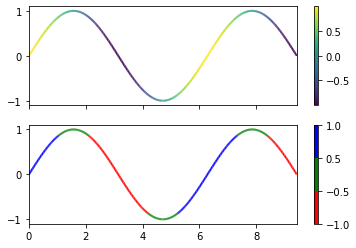

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()

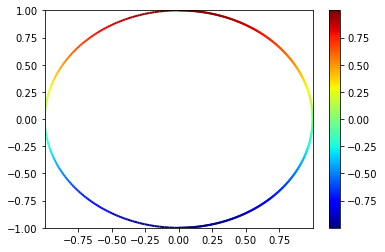

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from matplotlib.colors import ListedColormap, BoundaryNorm

# def plotMulticoloredLine(fig,ax,x_values,y_values,c_values,cmap='jet',use_colorbar=True,vmin=None,vmax=None):
#     '''x_values,y_values,c_values are each 1-by-N numpy arrays.'''
#     #define the relevant segments
#     points = np.array([x_values, y_values]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)

#     # Create a continuous norm to map from data points to colors
#     if vmin is None:
#         vmin=c_values.min()
#     if vmax is None:
#         vmax=c_values.max()
#     norm = plt.Normalize(vmin, vmax)
#     lc = LineCollection(segments, cmap=cmap, norm=norm)
#     # lc = LineCollection(segments, cmap='hot', norm=norm)
#     # Set the values used for colormapping
#     lc.set_array(c_values)
#     lc.set_linewidth(2)
#     line = ax.add_collection(lc)
#     if use_colorbar:
#         fig.colorbar(line, ax=ax)

#     # # Use a boundary norm instead
#     # cmap = ListedColormap(['r', 'k', 'b'])
#     # norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
#     # lc = LineCollection(segments, cmap=cmap, norm=norm)
#     # lc.set_array(dydx)
#     # lc.set_linewidth(2)
#     # line = ax.add_collection(lc)
#     # if use_colorbar:
#     #     fig.colorbar(line, ax=ax)
#     return fig,ax

# if __name__=='__main__':
#     x = np.linspace(0, 3 * np.pi, 500)
#     y = np.sin(x)
#     dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative
#     x_values=np.sin(x)
#     y_values=np.cos(x)
#     c_values=dydx

#     # Create a set of line segments so that we can color them individually
#     # This creates the points as a N x 1 x 2 array so that we can stack points
#     # together easily to get the segments. The segments array for line collection
#     # needs to be (numlines) x (points per line) x 2 (for x and y)

#     fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
#     fig, ax = plotMulticoloredLine(fig,ax,x_values,y_values,c_values,cmap='jet',use_colorbar=True)
# #     ax.set_xlim([0,width])
# #     ax.set_ylim([0,height])
#     ax.set_xlim(x_values.min(), x_values.max())
#     ax.set_ylim(y_values.min(), y_values.max())
#     plt.show()